In [255]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation, NMF

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
# from pyLDAvis import gensim_models as pg
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)


In [256]:
cwd = os.getcwd()
data = cwd + "/amazon_r.csv"

df = pd.read_csv(data)
print(df.shape)
df.head()

(1597, 27)


id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
3  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
4  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   

  reviews.rating  \
0            5.0   
1            5.0   
2            4.0   
3            5.0   
4            5.0   

                                                                                                                                                              reviews.sourceURLs  \
0  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
1  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
2  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
3  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
4  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   

                                                                                                                                                                                                                                                                                                  reviews.text  \
0  I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both m...   
1  Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others...   
2                                                                                                                       I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.   
3  I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reaso...   
4  I have to say upfront - I don't like coroporate, hermetically closed stuff li

In [257]:
df.asins.value_counts(normalize=True).nlargest(2)

B01BH83OOM    0.339386
B00CX5P8FC    0.103945
Name: asins, dtype: float64

In [258]:
# filter for product id = amazon echo and amazon fire TV
df = df[df['asins'].isin(["B01BH83OOM","B00CX5P8FC"])] 
df1=df[df['asins'].isin(["B01BH83OOM"])] # amazon tap
df2=df[df['asins'].isin(["B00CX5P8FC"])] # amazon fire tv
print(df.shape)

(708, 27)


## Preprocessing

In [259]:
df = df.drop(columns=['brand','categories','colors','dateAdded','dateUpdated','dimension','ean','keys','reviews.sourceURLs','reviews.userCity',
                      'reviews.userProvince','sizes','upc','weight','prices','reviews.doRecommend','reviews.numHelpful','reviews.rating','manufacturerNumber'
                     ,'manufacturer'], axis=1).sample(100)

df.head()

id       asins  \
1152  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
303   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
434   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
381   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
430   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   

                                                       name  \
1152  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
303                                          Amazon Fire TV   
434                                          Amazon Fire TV   
381                                          Amazon Fire TV   
430                                          Amazon Fire TV   

                  reviews.date  \
1152  2016-12-16T00:00:00.000Z   
303                        NaN   
434       2014-04-30T05:00:00Z   
381       2014-09-02T05:00:00Z   
430       2014-05-15T05:00:00Z   

                                                                                                                                                                                                                                                                                                     reviews.text  \
1152                                                                                                                                                                                                                purchased as a gift but I do have the Echo. If the echo works like the Echo it will be great.   
303   I am not a casual user of on-demand content and devices. Having tried smart tv's from 3 brands, smart dvd/bluray players, Apple TV, WDTV, HTPC, Chromecast and too many other competing products to mention--for streaming content, before this box you really had two options (for a simple to use box ...   
434   Amazon Fire TV is a must to have... Especially if you are paying the high prices of Cable TV/On Demand .etc I have cancelled those options am enjoying most of those same features on Amazon Fire TV.Movies, TV weekly shows, music, games. View on TV screen all photos, etc that have been saved on my...   
381   First I would like to say that I am coming from using Google TV. Fire TV is a great device. The voice search is accurate at picking up what I say. My biggest problem with this device is also with the voice search. Coming from Google TV if you used the search feature if would look for it in more ...   
430   After having the FireTV for about a month now, I can confidently recommend this product for most people. Versus the current generation Apple TV, ChromeCast and Roku offerings, the FireTV is the best value due to it's access to a wide variety of content, build quality and advanced features. It's ...   

                                                                                                                                                                                              reviews.title  \
1152                                                                                                                                                                            Unable to rate at this time   
303   This box is a GAME CHANGER for on demand content! Amazon knocked it out of the park. Refreshed UPDATED with Tips! and HBO GO! 26,759 people found this helpful. Was this review helpful to you Yes No   
434                                                                                                                                                                                          AMAZON FIRE TV   
381                                                                                                                                                Great device with some issues, but overall great device.   
430                                                                                                                    Best TV Streaming Box for Everyone - From Grandma to Your Computer Science Professor   

     reviews.username  
1152         Jayrock2  
303    William Hardin  
434      Arlene K

In [260]:
# Load the regular expression library
import re

# Remove punctuation
df['reviews_text_processed'] = \
df['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['reviews_text_processed'] = \
df['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['reviews_text_processed'].head()

1152                                                                                                                                                                                                                    purchased as a gift but i do have the echo if the echo works like the echo it will be great
303     i am not a casual user of on-demand content and devices having tried smart tv's from 3 brands smart dvd/bluray players apple tv wdtv htpc chromecast and too many other competing products to mention--for streaming content before this box you really had two options (for a simple to use box that do...
434     amazon fire tv is a must to have especially if you are paying the high prices of cable tv/on demand etc i have cancelled those options am enjoying most of those same features on amazon fire tvmovies tv weekly shows music games view on tv screen all photos etc that have been saved on my amazon cl...
381     first i would like to say that i am coming from using google tv fire

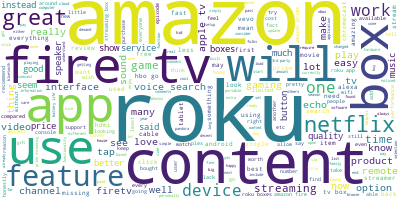

In [261]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [262]:
# Generating amazon tap word cloud
# Remove punctuation
df1['reviews_text_processed'] = \
df1['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df1['reviews_text_processed'] = \
df1['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df1['reviews_text_processed'].head()

852    important update (3/8/17): as you read my original review please be aware that amazon announced in early february (2017) a new firmware update that allows amazon tap owners to enable a hands-free option by going into settings in the alexa app you can now choose the hands-free option and have you...
853    it was just a few weeks ago that i was bemoaning the fact that i did not scoop up an echo back when they were being released last year not only could it be had at nearly half off the current price but it came with a voice remote and we could have had a year longer using this amazing devicewell h...
854    the amazon tap is a portable bluetooth speaker that can be controlled with your voice you can instruct it to play music order products and services control home automation products and connected devices plus a whole lot moreit contains a button activated microphone for listening to your verbal c...
855    look at this product as a portable speaker first and an echo replacement

In [263]:
#df1.get_document_topics(24)

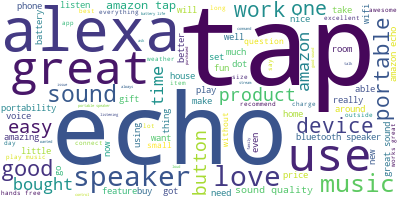

In [264]:
# Join the different processed titles together.
long_string = ','.join(list(df1['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [265]:
# Generating amazon fire tv word cloud
# Remove punctuation
df2['reviews_text_processed'] = \
df2['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df2['reviews_text_processed'] = \
df2['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df2['reviews_text_processed'].head()

288    an amazoncom official commented on this review(what's this) the amazon team saysjuly 30 2014hi dallas thank you for sharing your feedback we wanted to let you know that we made it easier to find your favorite prime content with the click of your remote you can now browse many more prime-only cat...
289    i'm your typical middle-aged woman - i don't game and i'm not super tech-savvy by any meansso take this review for what it is the fire tv was easy to install and i'm loving all the features free movies music and simple interface - this thing even has a screen saver that comes on when you're list...
290    having received my fire tv today i've been trying it out for the past couple of hourssetup was a no brainer it required an update immediately so it did take about 15 minutes to have it in action but the process was very simplethe image quality (movies and games) is excellent i've tried several m...
291    i'm your typical middle-aged woman - i don't game and i'm not super tech

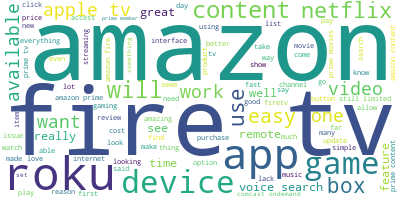

In [266]:
# Join the different processed titles together.
long_string = ','.join(list(df2['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## LDA Model

In [267]:
 # tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['first', 'would', 'like', 'to', 'say', 'that', 'am', 'coming', 'from', 'using', 'google', 'tv', 'fire', 'tv', 'is', 'great', 'device', 'the', 'voice', 'search', 'is', 'accurate', 'at', 'picking', 'up', 'what', 'say', 'my', 'biggest', 'problem', 'with', 'this', 'device', 'is', 'also', 'with', 'the', 'voice', 'search', 'coming', 'from', 'google', 'tv', 'if', 'you', 'used', 'the', 'search', 'feature', 'if', 'would', 'look', 'for', 'it', 'in', 'more', 'places', 'lets', 'say', 'am', 'searching', 'for', 'the', 'movie', 'gremlins', 'on', 'google', 'tv', 'it', 'would', 'look', 'for', 'it', 'in', 'netflix', 'amazon', 'instant', 'instant', 'prime', 'google', 'play', 'store', 'hbo', 'go', 'and', 'you', 'get', 'the', 'idea', 'this', 'device', 'for', 'example', 'will', 'not', 'check', 'netflix', 'so', 'must', 'do', 'voice', 'search', 'to', 'see', 'if', 'it', 'is', 'on', 'amazon', 'if', 'not', 'must', 'open', 'lets', 'say', 'netflix', 'and', 'use', 'the', 'up', 'down', 'left', 'right', 'buttons', '

In [268]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['to', 'screen', 'movies', 'for', 'music'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['purchased', 'gift', 'echo', 'echo', 'works', 'like', 'echo', 'great']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [269]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [270]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5)

# Print the Keyword in the 50 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"roku" + 0.016*"tv" + 0.014*"amazon" + 0.011*"box" + 0.010*"like" + '
  '0.009*"content" + 0.008*"streaming" + 0.008*"app" + 0.007*"fire" + '
  '0.006*"netflix"'),
 (1,
  '0.017*"tv" + 0.016*"roku" + 0.014*"amazon" + 0.012*"box" + 0.010*"fire" + '
  '0.009*"content" + 0.008*"like" + 0.007*"streaming" + 0.007*"use" + '
  '0.006*"app"'),
 (2,
  '0.022*"amazon" + 0.017*"tv" + 0.015*"roku" + 0.010*"fire" + 0.010*"box" + '
  '0.009*"content" + 0.007*"use" + 0.007*"netflix" + 0.006*"search" + '
  '0.006*"streaming"'),
 (3,
  '0.015*"great" + 0.011*"amazon" + 0.010*"echo" + 0.009*"one" + 0.008*"roku" '
  '+ 0.008*"tv" + 0.008*"like" + 0.007*"use" + 0.007*"love" + 0.006*"speaker"'),
 (4,
  '0.019*"tv" + 0.015*"amazon" + 0.015*"roku" + 0.012*"box" + 0.010*"content" '
  '+ 0.008*"use" + 0.008*"fire" + 0.008*"app" + 0.007*"like" + 0.007*"device"')]


In [271]:
def get_lda_topics(model, num_topics):
   word_dict = {};
   for i in range(num_topics):
       words = model.show_topic(i, topn = 20);
       word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
   return pd.DataFrame(word_dict);

In [272]:
#tops = sorted(doc_lda, reverse=True, key=lambda doc: abs(dict(doc).get(4, 0.0)))

In [273]:
#print(tops[:10])

In [274]:
#Create a dictionary, with topic ID as the key, and the value is a list of tuples 
#(docID, probability of this particular topic for the doc) 
#Loop over all the documents to group the probability of each topic
#topic_dict = {i: [] for i in range(20)}

#for doc in tops:
#     for topicID, prob in docID:
#            topic_dict[topicID].append((docID, prob))

#Then, you can sort the dictionary to find the top 20 documents:

#for topicID, probs in topic_dict.items():
#    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
#    docs_top_20 = [dp[0] for dp in doc_probs[:20]]  

In [275]:
#topic_dict

In [276]:
get_lda_topics(lda_model, num_topics)

Topic # 01 Topic # 02 Topic # 03 Topic # 04 Topic # 05
0        roku         tv     amazon      great         tv
1          tv       roku         tv     amazon     amazon
2      amazon     amazon       roku       echo       roku
3         box        box       fire        one        box
4        like       fire        box       roku    content
..        ...        ...        ...        ...        ...
15      great     search       easy     things       time
16      prime      apple      apple       also    quality
17        one      great       also      alexa     search
18      boxes      works      boxes       good        tap
19      voice       echo      voice    content     remote

[20 rows x 5 columns]

In [277]:
#calculating model perplexity

perplexity = lda_model.log_perplexity(corpus)

In [278]:
#printing model perplexity

print(perplexity)

-7.422317720899692


In [279]:
plist = []
for num in range(2, 51):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num)
    perplexity = lda_model.log_perplexity(corpus)
    plist.append(perplexity)
print(plist)

[-7.056111521748551, -7.142697183690514, -7.288569810898718, -7.490416710674887, -7.5242209252607575, -7.67259276929123, -7.758400993783087, -7.940345423664325, -8.218395557164104, -8.254022037922603, -8.289537570985685, -8.538533045581001, -8.666691310213656, -8.705628363669303, -8.76983941922155, -8.791966959397666, -8.960162043533863, -9.115971054993961, -9.279656597847481, -9.524000257625916, -9.415414704387107, -9.446387994734712, -9.71440020384718, -10.038630104010753, -9.956910227655987, -10.12546593905273, -10.261727636008791, -9.915251105101792, -10.374978173579306, -10.64011030115904, -10.57805055000942, -10.611961520905437, -10.707773995059943, -11.173670184198278, -11.114854356831339, -11.130463159752507, -10.997826725137791, -11.83803480178981, -11.45583181102595, -11.376840405014555, -11.604886193941388, -11.884836813090848, -11.64004412413793, -11.737700718040218, -12.399453767728088, -12.513661363330018, -12.066359681493003, -12.261243554415072, -12.669455713081016]


In [280]:
print(min(plist))

-12.669455713081016


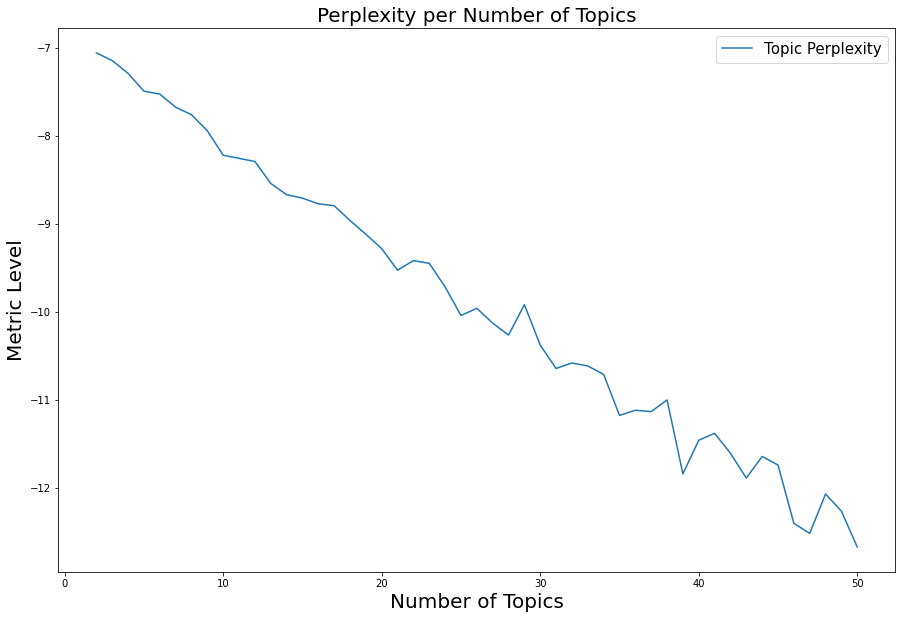

In [281]:
# visualization of Perplexity

plt.figure(figsize=(15,10))
ax = sns.lineplot(x=list(range(2,51)), y=plist, label='Topic Perplexity')

ax.axes.set_title('Perplexity per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

In [282]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, corpus=corpus,coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -2.9693001542486126


In [283]:
clist = []
for num in range(2, 51):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_words, 
                                         dictionary=id2word, 
                                         corpus=corpus,coherence='u_mass',

                                         )
    coherence_lda = coherence_model_lda.get_coherence()
    clist.append(coherence_lda)
print(clist)

[-1.5302142554092804, -1.6176942006848742, -1.457512410997954, -1.715367422221575, -1.4560853718902196, -2.020053142888826, -2.0988488689247737, -1.5483939193494198, -1.9372998134012203, -2.3801514484805466, -2.2779796191111514, -2.2397810137574914, -2.4993839735686363, -2.338426136395592, -1.9567025176492168, -2.460065963413878, -2.5570526538290914, -2.5540033608401393, -2.8391126968627876, -2.869134370199272, -2.935084484157244, -2.641004190524381, -2.6292792540042575, -2.7962650606312747, -3.1453354558408675, -3.30532513158474, -2.8035789178264414, -2.734968298457219, -2.699534916697723, -2.869256976324672, -2.2955198168996285, -3.621827408650714, -3.1630118226064012, -2.7112225886163808, -2.8364218645408577, -3.089094013725397, -3.212064426440854, -3.5402152869608985, -3.092049170881875, -2.97496471642009, -3.0574311849801226, -3.09297961747634, -3.4318050628858887, -2.9797294849308664, -2.9303405369221975, -3.4591041996181158, -3.383271281717956, -3.399495602374286, -3.25740154460

In [284]:
print(min(clist))

-3.621827408650714


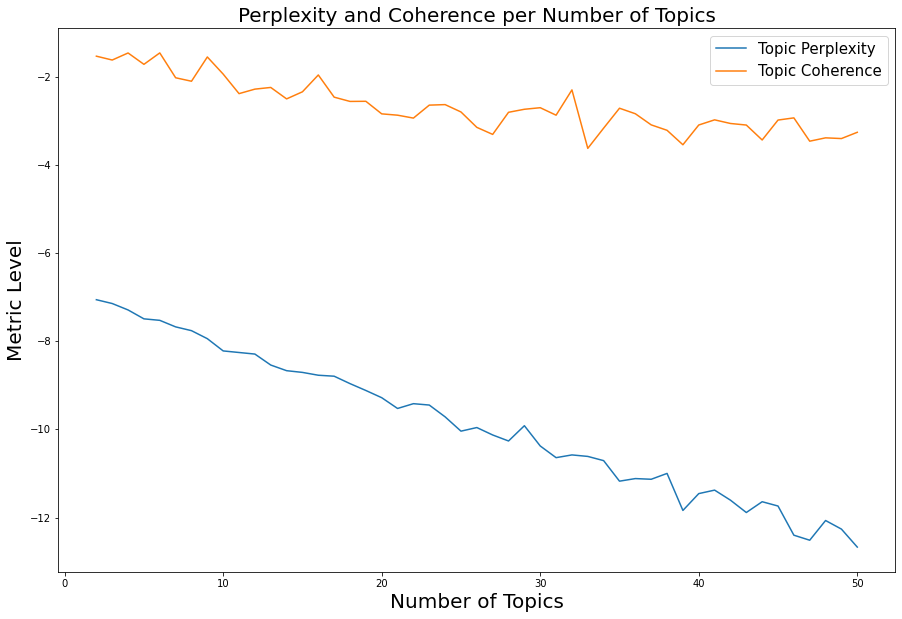

In [285]:
# visualization of Coherence & Perplexity

plt.figure(figsize=(15,10))
ax = sns.lineplot(x=list(range(2,51)), y=plist, label='Topic Perplexity')
ax = sns.lineplot(x=list(range(2,51)), y=clist, label='Topic Coherence')

ax.axes.set_title('Perplexity and Coherence per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

In [286]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationW

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
48    -0.016045 -0.012526       1        1  50.537023
15    -0.009700 -0.013869       2        1  10.897932
21    -0.144412 -0.005472       3        1  10.853469
4     -0.020082 -0.018858       4        1   4.823858
17     0.003112 -0.017935       5        1   3.086568
...         ...       ...     ...      ...        ...
39    -0.042333  0.005996      46        1   0.024177
27    -0.031458  0.008229      47        1   0.024177
41     0.012892  0.006838      48        1   0.024177
20     0.024479  0.010030      49        1   0.024177
49     0.003223 -0.002429      50        1   0.024177

[50 rows x 5 columns], topic_info=         Term        Freq       Total Category  logprob  loglift
107        tv  180.000000  180.000000  Default  30.0000  30.0000
12     amazon  173.000000  173.000000  Default  29.0000  29.0000
88       roku  107.000000  107.000000  Default  28.0000  28.0000
16        box   73.000000   73.000000  Default  27.0000  27.0000
125      fire   82.000000   82.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
76      price    0.006226   14.480953  Topic50  -5.6926   0.5756
196      time    0.006603   29.904437  Topic50  -5.6337  -0.0907
24   channels    0.006409   25.486426  Topic50  -5.6635   0.0394
13      apple    0.006549   39.698283  Topic50  -5.6420  -0.3823
116      well    0.006370   24.744739  Topic50  -5.6696   0.0628

[3198 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
675       1  0.263402  ability
675       2  0.263402  ability
1202      1  0.590217     abit
203       1  0.540223     able
203       2  0.135056     able
...     ...       ...      ...
1089      1  0.449273    years
439       1  0.606391      yes
439       5  0.101065      yes
1008      1  0.276012      yet
1008     13  0.276012      yet

[1793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[49, 16, 22, 5, 18, 20, 29, 46, 17, 8, 38, 13, 3, 44, 12, 34, 39, 48, 23, 43, 7, 2, 32, 10, 1, 27, 14, 30, 11, 19, 47, 45, 41, 26, 24, 6, 15, 4, 25, 9, 35, 36, 37, 33, 31, 40, 28, 42, 21, 50])

In [287]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word,corpus=corpus, coherence='u_mass')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [288]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20,30,40,50]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [289]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

alpha  num_topics  coherence_value
0    0.01           2        -1.964502
1    0.01           6        -1.620660
2    0.01          10        -1.946761
3    0.01          15        -2.441196
4    0.01          20        -2.652332
..    ...         ...              ...
19   1.00          15        -1.489476
20   1.00          20        -1.394108
21   1.00          30        -1.455166
22   1.00          40        -1.328402
23   1.00          50        -1.348765

[24 rows x 3 columns]

In [290]:
coherence_df.sort_values('coherence_value')

alpha  num_topics  coherence_value
15   0.10          50        -3.387240
5    0.01          30        -3.240195
7    0.01          50        -3.106807
13   0.10          30        -2.938267
12   0.10          20        -2.903817
..    ...         ...              ...
23   1.00          50        -1.348765
22   1.00          40        -1.328402
18   1.00          10        -1.213163
16   1.00           2        -0.920657
8    0.10           2        -0.846061

[24 rows x 3 columns]

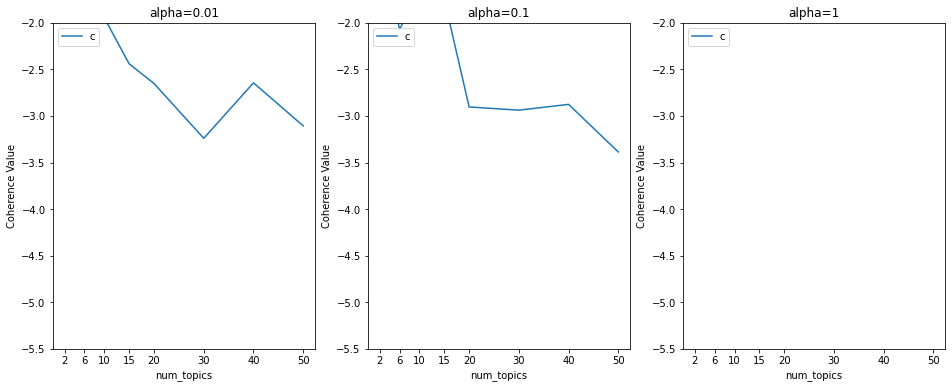

In [291]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([-5.5, -2])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

## Jaccard Score

In [292]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [293]:
# Considering 1-50 topics, as the last is cut off
num_topics = list(range(51)[1:])
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [294]:
shown_topics

[(0,
  [('amazon', 0.022110417),
   ('roku', 0.017859356),
   ('tv', 0.016572373),
   ('fire', 0.015965331),
   ('one', 0.014325382),
   ('content', 0.010292566),
   ('love', 0.009502472),
   ('use', 0.009342145),
   ('gaming', 0.008765409),
   ('watch', 0.007836558),
   ('search', 0.007830658),
   ('box', 0.0073067164),
   ('easy', 0.007175087),
   ('streaming', 0.006924812),
   ('netflix', 0.0065540704),
   ('options', 0.0062234597),
   ('room', 0.0057330485),
   ('things', 0.0053237984),
   ('install', 0.0051291175),
   ('chromecast', 0.00509842)]),
 (1,
  [('box', 0.017289756),
   ('content', 0.015819086),
   ('tv', 0.015505889),
   ('roku', 0.014702661),
   ('echo', 0.014114109),
   ('like', 0.012082958),
   ('netflix', 0.00916159),
   ('streaming', 0.008504116),
   ('use', 0.008456954),
   ('features', 0.007946831),
   ('fire', 0.0075292075),
   ('amazon', 0.0072744084),
   ('works', 0.0068705664),
   ('gaming', 0.0067393505),
   ('boxes', 0.006728282),
   ('app', 0.0062028277),


In [295]:
a = pd.DataFrame(shown_topics, columns=["topic number", "topic"]).transpose()

In [296]:
pd.options.display.max_colwidth = 300

In [297]:
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):  # more options can be specified also
    display(a)

0   \
topic number                                                                                                                                                                                                                                                                                                            0   
topic         [(amazon, 0.022110417), (roku, 0.017859356), (tv, 0.016572373), (fire, 0.015965331), (one, 0.014325382), (content, 0.010292566), (love, 0.009502472), (use, 0.009342145), (gaming, 0.008765409), (watch, 0.007836558), (search, 0.007830658), (box, 0.0073067164), (easy, 0.007175087), (streaming, 0.00...   

                                                                                                                                                                                                                                                                                                                       1   \
topic number                                                                                                                                                                                                                                                                                                            1   
topic         [(box, 0.017289756), (content, 0.015819086), (tv, 0.015505889), (roku, 0.014702661), (echo, 0.014114109), (like, 0.012082958), (netflix, 0.00916159), (streaming, 0.008504116), (use, 0.008456954), (features, 0.007946831), (fire, 0.0075292075), (amazon, 0.0072744084), (works, 0.0068705664), (gamin...   

                                                                                                                                                                                                                                                                                                                       2   \
topic number                                                                                                                                                                                                                                                                                                            2   
topic         [(use, 0.01610533), (box, 0.013807683), (app, 0.011849516), (roku, 0.011327676), (quality, 0.010460649), (easy, 0.01043576), (great, 0.010363628), (touch, 0.010058613), (must, 0.009858218), (sounds, 0.009857655), (activate, 0.009857056), (like, 0.0074431733), (tv, 0.007393581), (content, 0.00728...   

                                                                                                                                                                                                                                                                                                                       3   \
topic number                                                                                                                                                                                                                                                                                                            3   
topic         [(roku, 0.020462563), (tv, 0.0136768), (box, 0.013126212), (amazon, 0.011715248), (fire, 0.010856048), (netflix, 0.00736595), (streaming, 0.0072076577), (content, 0.0070529426), (gaming, 0.0065155365), (like, 0.0061889393), (use, 0.0061397147), (search, 0.0061002146), (app, 0.0059826486), (boxes...   

                                                                                                                                                                                                                                                                                                                       4   \
topic number                                                                                                                                                                              

In [298]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [299]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [300]:
#clist

In [301]:
coh_sta_diffs = [clist[i] - mean_stabilities[i] for i in range(num_topics[-2])] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [302]:
#coh_sta_diffs

In [303]:
ideal_topic_num

32

In [304]:
coh_sta_max

-3.867667859422191

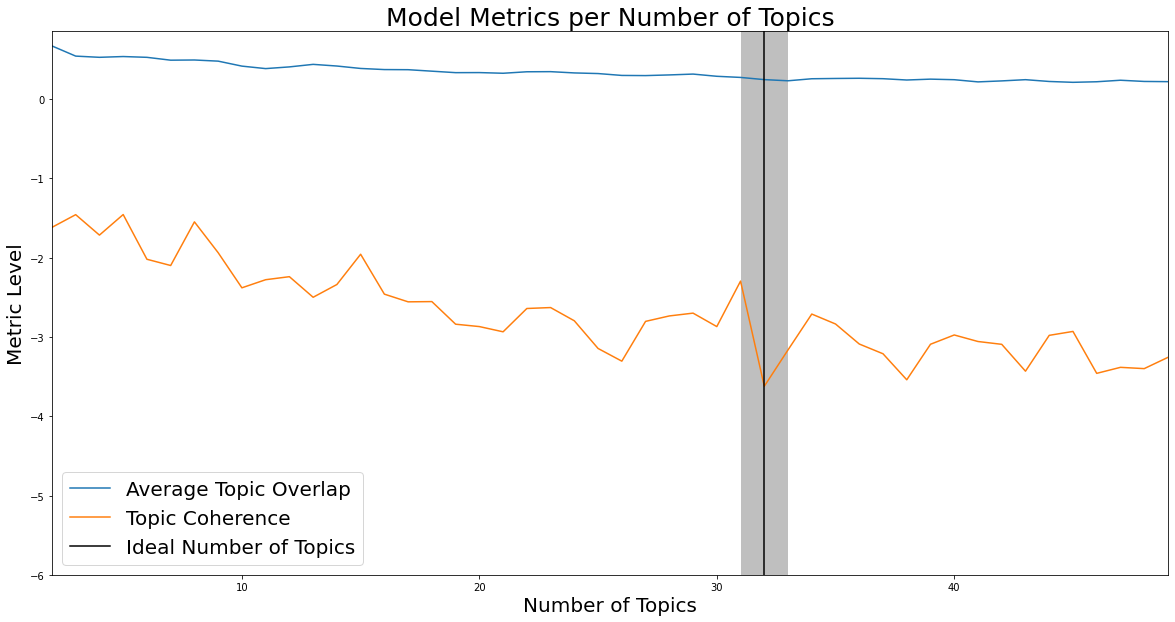

In [305]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=clist, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(clist)) + (0.10 * max(max(mean_stabilities), max(clist)))
ax.set_ylim([-6, y_max])
ax.set_xlim([2, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

## NMF Model

In [57]:
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

In [59]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
df["reviews.text"] = df["reviews.text"].apply(round1)

# Visually Inspect
df.head()

id       asins  \
895   AVpfpK8KLJeJML43BCuD  B01BH83OOM   
390   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
1039  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
976   AVpfpK8KLJeJML43BCuD  B01BH83OOM   
1391  AVpfpK8KLJeJML43BCuD  B01BH83OOM   

                                                       name  \
895   Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
390                                          Amazon Fire TV   
1039  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
976   Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
1391  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   

                  reviews.date  \
895   2017-07-21T00:00:00.000Z   
390       2014-09-03T05:00:00Z   
1039  2017-01-27T00:00:00.000Z   
976   2017-03-25T00:00:00.000Z   
1391  2017-06-08T00:00:00.000Z   

                                                                                                                                                                                                                                                                                                     reviews.text  \
895   i wouldn t buy it again   the software doesn t seem as well integrated with the hardware on this machine  i also have an echo and i don t have the same connectivity issues with it that i do with this  i liked the features available with this   portability mainly with a long battery life  but wit...   
390   i am sooo impressed with amazon fire tv  believe it or not  i sit and watch the screensaver lots a lot because the pictures are just that good  it is like taking a trip around the world  the amount of things you can do with this fire tv is pretty incredible to me  there is so much on here and th...   
1039                                                                                                                                                                                                   this is fun but would not buy again  not very informative  keeps say  i do not understand your question      
976                                                                                                                                                                                                                       i like its flexibility  portability and it is the best value option of all three alexas   
1391                                                                                                                                                                                                                           we bought this product to compliment our other amazon product for its portability    

                         reviews.title reviews.username  \
895           Not as great as the Echo           hulio5   
390            Small and yet sooo big.      Don Clayton   
1039  A little fun but not very useful      tinkerbell2   
976                 The Tab is awesome           SamMan   
1391                 Brilliant product      Langers1234   

                                                                                                                                                                                                                                                                                           reviews_text_processed  
895   i wouldn't buy it againthe software doesn't seem as well integrated with the hardware on this machine i also have an echo and i don't have the same connectivity issues with it that i do with this i liked the features available with thisportability mainly with a long battery life but with plagued...  
390   i am sooo impressed with amazon fire tv believe it or not i sit and watch the screensaver lots a lot because the pictures are just that good it is like taking a trip around the world the amount of things you can do with this fire tv is pretty incredible to me there is so much on here and that ca...  
1039                                                 

In [60]:
# Noun extract and lemmatize function

def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(df['reviews.text'].apply(nouns))
data_nouns = data_nouns.rename(columns={'reviews.text': 'text'})

# Visually Inspect
data_nouns.head()

text
895   i t software doesn t hardware machine i echo don t connectivity issue i feature portability battery life connectivity issue i review purchasing i one way sound
390            i sooo fire tv sit screensaver lot picture trip world amount thing fire tv apps amount thing fee rent i purchase unit i vacation tv hdmi favorite show
1039                                                                                                                                                  keep i question
976                                                                                                                     i flexibility portability value option alexas
1391                                                                                                                                      product product portability

In [61]:
# Add additional stop words since we are recreating the document-term matrix
stop_noun = [ 'screen', 'movies', 'music']
stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)

# Create a document-term matrix with only nouns

# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stop_words_noun_agg, ngram_range = (1,1), max_df = 1, min_df = .01)


# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data_nouns.text)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names_out())

# Set President's Names as Index
data_dtm_noun.index = df.index

# Visually inspect Document Term Matrix
data_dtm_noun.head()

accent  access  action  addition  age  alarm    alexas  animation  \
895      0.0     0.0     0.0       0.0  0.0    0.0  0.000000        0.0   
390      0.0     0.0     0.0       0.0  0.0    0.0  0.000000        0.0   
1039     0.0     0.0     0.0       0.0  0.0    0.0  0.000000        0.0   
976      0.0     0.0     0.0       0.0  0.0    0.0  0.707107        0.0   
1391     0.0     0.0     0.0       0.0  0.0    0.0  0.000000        0.0   

      anysolution  arabia  ...  wemo   wi  winner  wold  word  workaround  \
895           0.0     0.0  ...   0.0  0.0     0.0   0.0   0.0         0.0   
390           0.0     0.0  ...   0.0  0.0     0.0   0.0   0.0         0.0   
1039          0.0     0.0  ...   0.0  0.0     0.0   0.0   0.0         0.0   
976           0.0     0.0  ...   0.0  0.0     0.0   0.0   0.0         0.0   
1391          0.0     0.0  ...   0.0  0.0     0.0   0.0   0.0         0.0   

         world  xmas  yard  yearbook  
895   0.000000   0.0   0.0       0.0  
390   0.333333   0.0   0.0       0.0  
1039  0.000000   0.0   0.0       0.0  
976   0.000000   0.0   0.0       0.0  
1391  0.000000   0.0   0.0       0.0  

[5 rows x 258 columns]

In [62]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
#'''Given an NMF model, feature_names, and number of top words, print topic number 
#and its top feature names, up to specified number of top words.'''    
    
    # iterate through topics in topic-term matrix
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [63]:
nmf_model = NMF(50)

# Learn an NMF model 
# Extract the document-topic matrix 
doc_topic = nmf_model.fit_transform(data_dtm_noun)

# Extract top words from the topic-term matrix  
display_topics(nmf_model, tv_noun.get_feature_names(), 10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic  0
expectation, friend, library, vudu, hbo, light, brain, potential, thermostat, extension

Topic  1
highlight, toy, limitation, clip, fi, cover, wi, stutter, traffic, brother

Topic  2
easy, ebooks, genre, gathering, garage, gap, ganes, gadget, functionality, function

Topic  3
bed, store, speaking, planning, ijnfo, guess, glad, inna, im, fi

Topic  4
genre, team, feedback, official, click, expense, experience, edit, gathering, garage

Topic  5
ease, piece, dozen, edit, experience, controller, godsend, parent, animation, logo

Topic  6
alexas, flexibility, spotify, ue, namesake, jbl, faras, snap, winner, graphic

Topic  7
eco, mobility, wall, produce, file, firmware, fit, flexibility, format, friend

Topic  8
sale, replaces, tag, trick, distance, library, hbo, vudu, delight, snap

Topic  9
availability, loyalist, format, line, firmware, memory, file, gap, gun, plex

Topic  10
connect, usage, sport, seamless, family, conpack, gadget, ganes, functionality, file

Topic  11
grandda

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [64]:
#doc_topic

In [65]:
#nmf_model.transform(data_dtm_noun)

In [66]:
#docs_topic = pd.DataFrame(doc_topic)

In [67]:
#docs_topic()

In [68]:
#for topic in 

In [69]:
#show_topics = (nmf_model, 10, None)
#print(show_topics)

In [70]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = data_nouns.text


# for each number of topics
coherence_scores = []

for num in range(1,51):
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=id2word
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        corpus=corpus,
        dictionary=id2word,
        coherence='u_mass'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
print(coherence_scores)

[-3.41285, -4.8338, -3.84382, -2.45205, -2.77162, -2.99433, -3.0052, -3.55559, -3.15126, -3.08712, -3.13074, -3.76336, -4.12601, -3.35288, -3.68764, -3.11179, -4.05165, -4.36682, -3.4497, -3.71441, -3.49245, -5.12982, -3.25629, -3.85494, -4.75412, -5.04078, -4.232, -4.01455, -4.68133, -4.4753, -3.76721, -4.5401, -4.65233, -4.85102, -5.01854, -4.69554, -4.8924, -4.39325, -5.79482, -5.30478, -4.93296, -4.79014, -5.41762, -5.77948, -4.79157, -5.19271, -5.10777, -5.51216, -5.36331, -5.30587]


In [71]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [72]:
nmf.show_topics(num_topics=15, num_words=10, log=True, formatted=True, normalize=None)

[(41,
  '0.056*"device" + 0.036*"app" + 0.034*"roku" + 0.023*"get" + 0.022*"video" + 0.021*"devices" + 0.021*"works" + 0.021*"netflix" + 0.019*"great" + 0.017*"amazon"'),
 (19,
  '0.044*"good" + 0.040*"hands" + 0.028*"product" + 0.026*"great" + 0.021*"wold" + 0.020*"dot" + 0.020*"ordered" + 0.020*"close" + 0.020*"returned" + 0.020*"sitting"'),
 (38,
  '0.080*"device" + 0.035*"great" + 0.032*"app" + 0.027*"amazon" + 0.027*"sound" + 0.027*"little" + 0.025*"bluetoothdecent" + 0.025*"connect" + 0.023*"works" + 0.021*"netflix"'),
 (14,
  '0.040*"tv" + 0.035*"fire" + 0.029*"even" + 0.027*"echo" + 0.014*"may" + 0.014*"love" + 0.013*"could" + 0.013*"year" + 0.012*"voice" + 0.012*"external"'),
 (35,
  '0.080*"apple" + 0.074*"content" + 0.056*"tv" + 0.053*"roku" + 0.045*"wdtv" + 0.026*"reason" + 0.025*"use" + 0.023*"quick" + 0.022*"lacks" + 0.018*"box"'),
 (39,
  '0.051*"alexa" + 0.036*"tap" + 0.024*"review" + 0.023*"bed" + 0.023*"details" + 0.023*"nite" + 0.019*"dock" + 0.019*"well" + 0.016*"wa

In [73]:
# Considering 1-51 topics, as the last is cut off
num_topics = list(range(51)[1:])
num_keywords = 50

NMF_models = {}
NMF_topics = {}
for i in num_topics:
    NMF_models[i] = Nmf(
        corpus=corpus,
        num_topics=i,
        id2word=id2word,
        random_state=42
    )

    shown_topics = NMF_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    NMF_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [74]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [75]:
NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(NMF_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(NMF_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

In [76]:
coherences = [CoherenceModel(model=NMF_models[i], texts=corpus, dictionary=id2word, corpus=corpus,coherence='u_mass').get_coherence()\
              for i in num_topics[:-1]]

In [77]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_topics[-2])] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [78]:
ideal_topic_num

37

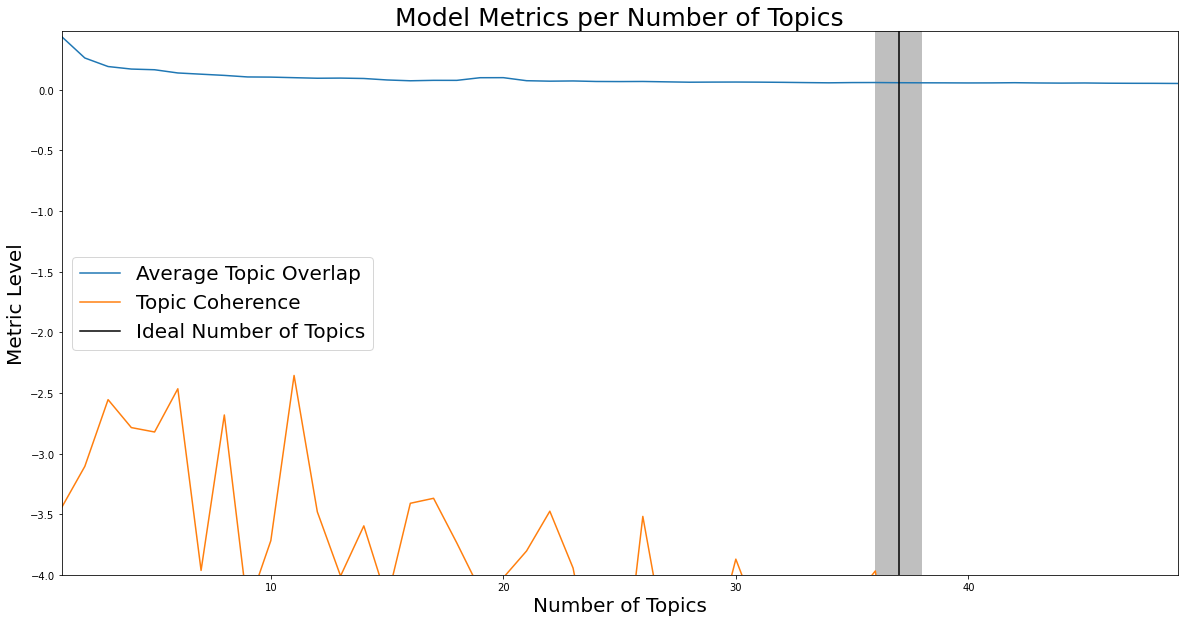

In [79]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([-4, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [80]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


## Corex Model

In [81]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [82]:
# Transform data into a sparse matrix
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(data_nouns.text)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(100, 459)

In [83]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [84]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(100, 459)

## Unsupervised Corex model 

In [97]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=45, words=words, max_iter=200, verbose=False, seed=12)
topic_model.fit(doc_word, words=words);

In [98]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: comcast, dvr, mean, oh, ondemand, saver, tech, woman, recognition, release
1: week, feel, ability, fact, something, home, texas, stutter, stain, typing
2: player, wdtv, reason, term, tail, summary, site, simple, htpc, bluray
3: brainer, package, about, oversight, pay, process, purpose, ray, return, section
4: kid, assumption, stick, priority, plex, official, need, morning, miss, memory
5: work, side, saudi, piece, parent, logo, load, thanks, animation, experience
6: back, wall, usb, system, son, sling, school, produce, person, mobility
7: apps, selection, show, unit, favorite, fee, hdmi, like, screensaver, sit
8: box, search, speed, user, market, cd, netflix, video, anything, disclaimer
9: convenient, news, bed, speaking, planning, outside, limitation, ijnfo, highlight, guess
10: case, buy, room, computer, fabric, future, blue, step, responds, request
11: review, cost, savvy, feature, look
12: list, people, place, power, skill, smartphone, call, company, grow, iffy
13: tv, fire, con

In [99]:
topic_model

In [100]:
topic_model.tc

16.79746270807638

In [101]:
tc_list = []
for i in range(2,50):
    topic_model = ct.Corex(n_hidden=i, words=words, max_iter=200, verbose=False, seed=1)
    topic_model.fit(doc_word, words=words);
    #topic_model.get_top_docs(topic=i, n_docs=10, sort_by='log_prob')
    tc_list.append(topic_model.tc)

In [102]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

18.034510825290443
18.034510825290443


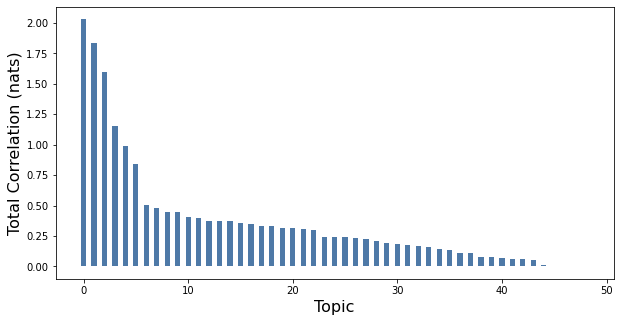

In [103]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

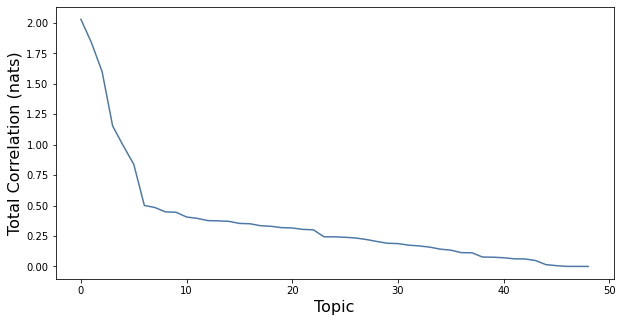

In [104]:
plt.figure(figsize=(10,5))
plt.plot(range(topic_model.tcs.shape[0]),topic_model.tcs, color='#4e79a7')
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.show()

## Semi-Supervised Corex Topic Modeling

In [105]:
# Anchor one word to each topic
anchor_words = [['activity'],['reader'],['display'], ['gaming'],['company'], ['roku'], ['niche'], ['streaming'],['hbo'],['texas'],['software'],
                ['app'], ['internet'], ['comcast'], ['service'], ['hardware'], ['beef'], ['tv'], ['sale'], ['store'], ['anybody'],['problem'],
                ['accessory'],['wifi'],['family'],['siri'],['review'],['try'],['ability'],['computer'],['amazon'],['speaker'],['christmas'],
                ['firetv'],['room'],['south'],['gathering'],['awesome'],['weather'],['choice'],['tune'],['stand'],['tech'],['battery'],
                ['netflix'],['son'],['access'],['functionality'],['pro'],['news']]

In [106]:
# Anchor the word 'activity' to the first topic, 'reader' to the second topic, and so on...
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [107]:
# loop through and show each of the most relevant words
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: company, thank, official, integration, im, iffy, glad, genre, age, friend
1: roku, box, reason, speed, user, wdtv, device, player
2: niche, lot, bluray, site, htpc, head, summary, tail, term, demand
3: hbo, apps, complaint, selection, show, unit, library, like, others, vudu
4: texas, level, audiophile, drag, eco, except, mobility, produce, system, wall
5: software, game, network
6: app, future, place, skill, smartphone, capability, call, grow, samsung, task
7: internet, brain, extension, light, potential, step, substitute, thermostat
8: comcast, member, movie, thing, voice
9: service, tag, trick
10: hardware, portability, alexas, don, flexibility, machine, one, purchasing
11: tv, fire, apple, content, interface, search, port
12: sale, replaces, cd
13: store, bed, cant, detail, guess, ijnfo, intro, planning, smartness, speaking
14: problem, disclaimer, print, command
15: wifi, card, host, lake, while
16: family, day, chart, laptop, seamless, sport, usage
17: review, cost, feature, lo

In [108]:
# store a file to my local drive
vt.vis_rep(topic_model, column_label=words, prefix='Qinren_Corex')

Print topics in text file


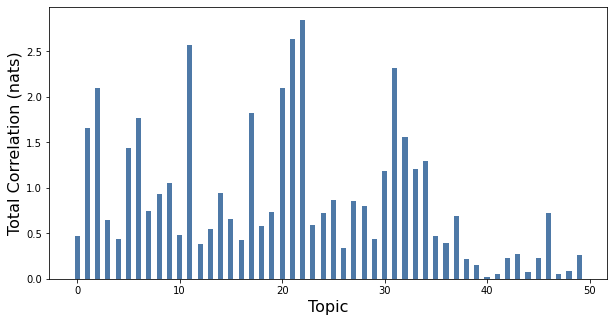

In [109]:
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## Biterm

In [165]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary

stpwrd = nltk.corpus.stopwords.words('english')
new_stopwords=['activity','reader','display']
stpwrd.extend(new_stopwords)
vec = CountVectorizer(stop_words=stpwrd)
X = vec.fit_transform(data_nouns.text).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)
from biterm.cbtm import oBTM

btm1 = oBTM(num_topics=50, V=vocab)
topics = btm1.fit_transform(biterms, iterations=50)

100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.24it/s]


In [166]:
topic_summuary(btm1.phi_wz.T, X, vocab, 10)

Topic 0 | Coherence=-34.29 | Top words= quality tv everyone price feature option lot look market remote
Topic 1 | Coherence=-2.32 | Top words= wdtv content future amount file consideration memory gun gap itunes
Topic 2 | Coherence=-10.29 | Top words= yearbook godsend fi file fire firetv firm firmware fit flexibility
Topic 3 | Coherence=-11.49 | Top words= start home stage smartness package job inna fi file fire
Topic 4 | Coherence=-40.02 | Top words= music device navigation quality member dlna setup option case apple
Topic 5 | Coherence=-55.44 | Top words= tap hand alexa phone dot kid button year mom ganes
Topic 6 | Coherence=-49.88 | Top words= point music price lot button dot sort chance gadget coll
Topic 7 | Coherence=-33.04 | Top words= pay tv game member quality thing apps button network return
Topic 8 | Coherence=-53.64 | Top words= amazon review day alexa tap stand ijnfo bed store calendar
Topic 9 | Coherence=-53.04 | Top words= button tap command downside item product sound tri

{'coherence': [-34.290605496503424,
  -2.3219475876565827,
  -10.292975706121153,
  -11.489208938352911,
  -40.021544203956516,
  -55.43638856611733,
  -49.88188257718068,
  -33.03946044621783,
  -53.64454786643967,
  -53.04199570805972,
  -40.57222109704901,
  -64.25582631812125,
  -24.300057907965844,
  -19.997036233960383,
  -55.384010405083075,
  -13.306941960957873,
  -32.1988454479765,
  -49.72271624448798,
  -21.840716669112723,
  -42.592757945241225,
  -35.707720466237696,
  -28.21860948174281,
  -44.789652590695354,
  -19.920525335049717,
  -13.52617964890738,
  -43.37390543517148,
  -10.248573136246735,
  -37.77281543255593,
  -42.6286620989207,
  -30.598112122567773,
  -25.418948097448986,
  -35.015391082870785,
  -53.66615535280134,
  -25.874829042104334,
  -14.821184850973111,
  -32.84580637845237,
  -37.63304717001797,
  -55.06684169317635,
  -44.805891336487626,
  5.545177444479561,
  -54.53483046666421,
  -30.613199987551422,
  -33.0157436619198,
  -44.01073700262761,
 

In [167]:
for i in range(0, 1): 
        biterms_chunk = biterms[i:i + 100]
        btm1.fit(biterms_chunk, iterations=10)

print("\n\n Topic coherence ..")
res, C_z_sum = topic_summuary(btm1.phi_wz.T, X, vocab, 10)
print(res)

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.22it/s]



 Topic coherence ..
Topic 0 | Coherence=-38.61 | Top words= quality option tv apple feature amazon everyone device product price
Topic 1 | Coherence=-8.80 | Top words= wdtv content future amount consideration memory fire gap model inability
Topic 2 | Coherence=-10.29 | Top words= yearbook godsend fi file fire firetv firm firmware fit flexibility
Topic 3 | Coherence=-11.72 | Top words= home start stage smartness inna package job feature file fire
Topic 4 | Coherence=-41.54 | Top words= device music quality member dlna navigation category thing case apple
Topic 5 | Coherence=-57.40 | Top words= alexa tap dot hand kid amazon phone button ganes mom
Topic 6 | Coherence=-49.19 | Top words= point music price lot dot button chance coll gadget control
Topic 7 | Coherence=-37.94 | Top words= tv quality button member return way pay fire installation game
Topic 8 | Coherence=-44.96 | Top words= amazon review day alexa calendar news guess store bed planning
Topic 9 | Coherence=-58.24 | Top words=

In [168]:
import bitermplus as btm
import numpy as np
import pandas as pd
import tmplot as tmp
import plotly.express as px

In [169]:
# Importing data

texts = data_nouns.text.str.strip().tolist()

# Vectorizing documents, obtaining full vocabulary and biterms
# Internally, btm.get_words_freqs uses CountVectorizer from sklearn
# You can pass any of its arguments to btm.get_words_freqs
# For example, you can remove stop words:
stop_words = ['activity','reader','display', 'thing']
X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [170]:
# INITIALIZING AND RUNNING MODEL
plist=[]
clist=[]

for n in range(1,51):
    model = btm.BTM(X, vocabulary, seed=1221, T=n, M=15, alpha=50/8, beta=0.1)
    model.fit(biterms, iterations=10)
    p_zd = model.transform(docs_vec)
    perplexity = model.perplexity_
    plist.append(perplexity)
    coherence = model.coherence_
    clist.append(coherence)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 61527.12it/s]


In [171]:
clist 

[array([-132.58130095]),
 array([ -65.3605368 , -142.38948988]),
 array([ -60.78903145, -124.416073  , -121.81571927]),
 array([ -54.53060615, -113.07089356, -137.45417998,  -60.89402682]),
 array([ -85.81054639,  -62.89303876, -123.77613625, -145.78607111,
         -50.00168496]),
 array([ -59.49026708, -117.64680272,  -89.33172015, -118.835232  ,
        -150.05065286,  -51.12060528]),
 array([ -45.14149865, -107.37268336, -133.28531302, -119.59711937,
        -121.68637668, -125.63269603,  -77.58903171]),
 array([ -60.6072285 , -111.77257975, -103.56638763, -130.11996737,
        -124.88989402, -166.12708024, -142.93330967,  -39.43112059]),
 array([ -45.02371562, -101.27916633, -102.3294242 , -137.32117159,
        -112.34011735, -119.06499087, -146.50071281, -125.9900072 ,
         -42.40553279]),
 array([ -60.00397275,  -94.93978597,  -80.28054473, -156.51698445,
         -49.94624209, -126.62572821, -162.51828359, -111.76921531,
        -128.49508944,  -33.30292208]),
 array([ -6

In [172]:
# Metrics
import numpy as np
#print(plist)

coherence_means = []

perplexity = []

for i in clist:
    mean = np.ma.masked_invalid(i).mean()
    coherence_means.append(mean)
for j in plist:
    perplexity.append(j)

print(coherence_means)
print(perplexity)

[-132.58130095191774, -103.87501334141876, -102.34027457208215, -91.48742662610097, -93.65349549607444, -97.74588001668148, -104.32924554607409, -109.93094597167018, -103.58387097255746, -100.43987686160897, -100.18085856904715, -96.03639950469028, -95.89829049697526, -94.13532201639234, -97.68481453586395, -92.96856925083557, -93.45340913838214, -91.20349019606955, -97.80099036840268, -86.36795495931837, -83.64945982922465, -87.96404172529664, -83.00109861673342, -86.93890526995602, -86.66941716518568, -85.32582700946432, -83.2799481841313, -84.14198959105866, -83.95373640446172, -82.24143954506039, -83.15362439058342, -78.85219269208093, -76.36434413932905, -80.54012510489589, -76.77699516906117, -81.30335595555579, -75.86466260373855, -79.00138971490455, -74.65914861752844, -77.78945640147431, -76.3407919196429, -78.02037825720926, -73.77736275209423, -80.11583325987272, -76.73593620803754, -72.12769686998081, -75.96794848549078, -68.92816553143352, -67.24027623063225, -72.140397938

In [173]:
# # Metrics
# import numpy as np
# #print(plist)

# coherence_means = []

# perplexity = []

# for i in clist:
#     mean = i.mean()
#     coherence_means.append(mean)
# for j in plist:
#     perplexity.append(j)

# print(coherence_means)
# print(perplexity)

In [174]:
min(coherence_means)

-132.58130095191774

In [175]:
max(perplexity)

259.2037101595415

In [176]:
cdf = pd.DataFrame({'Average Coherence':coherence_means, 'Perplexity':perplexity})
cdf.insert(0, 'Topic Number', range(0, 0 + len(cdf)))
cdf

Topic Number  Average Coherence  Perplexity
0              0        -132.581301  259.203710
1              1        -103.875013  170.964220
2              2        -102.340275  150.846903
3              3         -91.487427  123.193180
4              4         -93.653495  118.523580
5              5         -97.745880  105.005850
6              6        -104.329246  105.587364
7              7        -109.930946   90.821354
8              8        -103.583871   89.634624
9              9        -100.439877   88.866632
10            10        -100.180859   86.602518
11            11         -96.036400   77.737806
12            12         -95.898290   73.693326
13            13         -94.135322   74.365170
14            14         -97.684815   69.100391
15            15         -92.968569   70.311901
16            16         -93.453409   73.502676
17            17         -91.203490   63.083936
18            18         -97.800990   61.887325
19            19         -86.367955   61.144949
20            20         -83.649460   63.693876
21            21         -87.964042   59.191655
22            22         -83.001099   54.592672
23            23         -86.938905   60.555469
24            24         -86.669417   56.967170
25            25         -85.325827   55.569753
26            26         -83.279948   53.555249
27            27         -84.141990   58.134338
28            28         -83.953736   55.996920
29            29         -82.241440   52.614989
30            30         -83.153624   53.836898
31            31         -78.852193   51.860337
32            32         -76.364344   52.033946
33            33         -80.540125   49.152719
34            34         -76.776995   52.880261
35            35         -81.303356   50.932433
36            36         -75.864663   50.040738
37            37         -79.001390   49.294818
38            38         -74.659149   46.838137
39            39         -77.789456   48.216620
40            40         -76.340792   48.006460
41            41         -78.020378   46.671062
42            42         -73.777363   45.716277
43            43         -80.115833   48.166481
44            44         -76.735936   45.653648
45            45         -72.127697   43.449830
46            46         -75.967948   45.220316
47            47         -68.928166   45.310532
48            48         -67.240276   43.754267
49            49         -72.140398   46.486564

In [177]:
fig=px.line(cdf, x='Topic Number', y=cdf.columns[1:3], template='plotly_white', color='variable')

fig.update_xaxes(nticks=20)
fig.update_layout(bargap=0.05)
fig.show()

In [178]:
# LABELS
model.labels_

array([40, 12, 11,  2, 37,  4, 26,  4,  3, 26,  0, 22, 19,  4, 21,  9,  3,
       46, 34, 22, 14, 28, 42, 18, 46, 48,  3, 33,  4, 41, 23, 18,  4, 26,
       25, 37, 43, 44, 43, 46, 47, 34, 38, 26,  5, 48, 46, 34, 19, 34, 46,
        8, 26,  8,  6, 13, 41, 34, 46, 22, 39, 11, 34, 34, 34, 34,  6,  4,
       27, 34, 26, 47, 42,  6,  4,  4, 15, 34, 41,  7, 32, 44, 46, 35, 37,
        9, 47, 22, 36, 30, 47, 34, 37, 49, 46, 31, 48, 29,  1, 22])

In [229]:
#tmp.report(model=model, docs=texts, width=200, height=700)

In [180]:
doc_topics = btm.get_docs_top_topic(texts, model.matrix_docs_topics_)
doc_topics['topic'] = doc_topics['label']+1
doc_topics.topic.value_counts()

35    12
5      8
47     8
27     6
23     5
48     4
38     4
7      3
49     3
42     3
4      3
20     2
10     2
9      2
45     2
43     2
19     2
12     2
44     2
8      1
28     1
16     1
41     1
33     1
36     1
37     1
40     1
50     1
32     1
30     1
31     1
24     1
14     1
6      1
39     1
26     1
13     1
34     1
29     1
15     1
22     1
1      1
3      1
2      1
Name: topic, dtype: int64

In [181]:
doct = doc_topics['topic'].value_counts()
doct = pd.DataFrame(doct).reset_index().rename(columns={'index':'Topic','topic':'Number of Documents'})

In [182]:
fig=px.bar(doct, x='Topic', y='Number of Documents', template='plotly_white', color='Number of Documents')
fig.update_xaxes(nticks=40)
fig.update_layout(bargap=0.05)
fig.show()

In [184]:
doc_topics = doc_topics.sort_values(by='topic', ascending=True)
pd.set_option('display.max_rows', doc_topics.shape[0]+1)
doc_topics

documents  \
10                                                                                                                                                                                                                                                                                                                
98                                                                                                                                                                                                                          thought grow i list task app smartphone s list place call echo i samsung smartphone   
3                                                                                                                                                                                                                                                                 i flexibility portability value option alexas   
26                                                                                                                                                                                                                                                                                            product grandkids   
16                                                                                                                                                                                                                                                                                            thank product age   
8                                                                                                                                                                                                                                                                                                  product item   
5                                                                                                                                                                                                                                                                          camera daughter yearbook school love   
7                                                                                                                                                                                                                                                                                sound speaker good information   
32                                                                                                                                                                                                                                                                    value quality speaker information highway   
28                                                                                                                                                                                                                                                                                        i sound sound conpack   
75                                                                                                                                                                              hi everyone alexa feel week speaker love music everything fact something event time home assistant assist calendar word awesome   
13                                                                                                                                                                                                                                                                      product sound part sound yard gathering   
67                                                                                                                                                                     software update hand mode everything echo speaker t device everything i time tap sound quality speaker size choice hotspot data alexa go

In [185]:
dp = btm.get_top_topic_docs(texts, p_zd, docs_num=10, topics_idx=range(11,21))
pd.set_option('display.max_rows', dp.shape[0]+1)
dp.to_csv(cwd + "top_docs.csv")
dp


topic11  \
0                                                                                                                                                                                                                                                                                              keep i question   
1                                                                                                                                                                                              family tap day information weather question sport battery life day usage connectivity seamless connection house   
2                                                                                                                                                                                                                            i amazon tap i music i music account pandora phone question question everything i   
3                                                                                                                                                                                                                                                       integration music phone interface iffy product company   
4                                                                                                                                                                                                                                                      product job voice command while problem wifi connection   
5  bluetooth speaker tap sound quality loud quality stutter echo i room room charging stand tap time button voice command issue something hand brother echo device hand place power cord feel tap fabric cover hand fabric upholstery cover stain i bare plastic i wireless i music alexa question fun i li...   
6                                                                                                                                                                                                                                                                          setup love wireless fun information   
7                                                                                                                                                                                                                                             i speaker song alexa access information quicker phone google com   
8                                                                                                                                                                                                                                                     kitchen sound cooking timer alarm event day music source   
9                                                                                                                                                                                                                                                i hour day wemo device battery life quality voice recognition   

                                                                                                                                                                                                                                                                                                       topic12  \
0                                                                                                                                                       i sooo fire tv sit screensaver lot picture trip world amount thing fire tv apps amount thing fee rent i purchase unit i vacation tv hdmi favorite show   
1                                                                                                                                                                                                    i voice search speed unit thing t like i apps thing fire tv app selection tv roku tv watching device roku   
2         

In [186]:
import graphviz as gv

In [227]:
g = gv.Graph('g', engine='sfdp')
g.attr(rankdir = 'LR', size = '10,10')
g.node('Tap', shape = 'box')
g.node('Mobile Speaker', shape = 'box', color = 'green')
g.node('Streaming Devices', shape = 'box', color = 'blue')
g.edge('Mobile Speaker', 'Streaming Devices')
g.edge('Mobile Speaker', 'Music')
g.edge('Music', "Great sound quality")
g.edge('Mobile Speaker', 'Room')
g.edge('Room', 'Garage')
g.edge('Garage', 'Long distance bluetooth')
g.edge('Garage', 'Free hands')
g.edge('Room', 'Kitchen')
g.edge('Kitchen', 'Free hands')
g.edge('Mobile Speaker', 'Alexa')
g.edge('Alexa', 'remote control and convenient')
g.edge('Alexa', 'easy to operate')
g.edge('Mobile Speaker', 'Family')
g.edge('Mobile Speaker', 'Tap')
g.edge('Tap', 'Works great with Alexa to improve portability')
g.edge('Streaming Devices', 'roku/netflix and other streaming services')
g.edge('Streaming Devices', 'Tap')
g.edge('Streaming Devices', 'voice search')
g.edge('voice search', 'Easily obtain information without using phone')
g.edge('Streaming Devices', 'Great image quality and categories')
g.edge('Great image quality and categories', 'Safe for certain groups of people like kids')

In [209]:
g.view()

'g.gv.pdf'

In [228]:
g.render(filename= cwd + "/test.svg")

'/Users/qinrenkang/Desktop/QINREN-KANG-MIDTERM/test.svg.pdf'